# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# importamos las librerias necesarias
import os
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/') # Path del dataset
print(path)
images_train = sorted([path/'train'/i for i in os.listdir(path/'train')]) # path de las imagenes de entrenamiento
print(images_train)
mascaras_train = sorted([path/'trainmask'/i for i in os.listdir(path/'trainmask')]) # path de las mascaras de entrenamiento
print(mascaras_train)
images_test = sorted([path/'valid'/i for i in os.listdir(path/'valid')]) # path de las imagenes de test
mascaras_test = sorted([path/'validmask'/i for i in os.listdir(path/'validmask')]) # path de las mascaras de test

/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation
[PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.129f37b9157824afa37e7001fff33651.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.6668c272da0b321fc4ad1f96f3d49438.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.ed3cb2b06ba03df3a9bedce9c7662587.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.4b377c8ce4064ebdfcf3ad38973ac605.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.73f635b6dc214e6d16382f60470ceba7.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.90decd94dc20c9d56c0c55c380561998.jpg'), PosixPath('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_101_jpg.rf.9d50d60f156

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [5]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.

        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)

        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)

    return np.array(imagenes), np.array(mascaras)

In [6]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (61, 394, 394, 3)
Forma de las máscaras numpy: (61, 394, 394, 4)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [7]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [8]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((394, 394, 3), (394, 394, 4))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

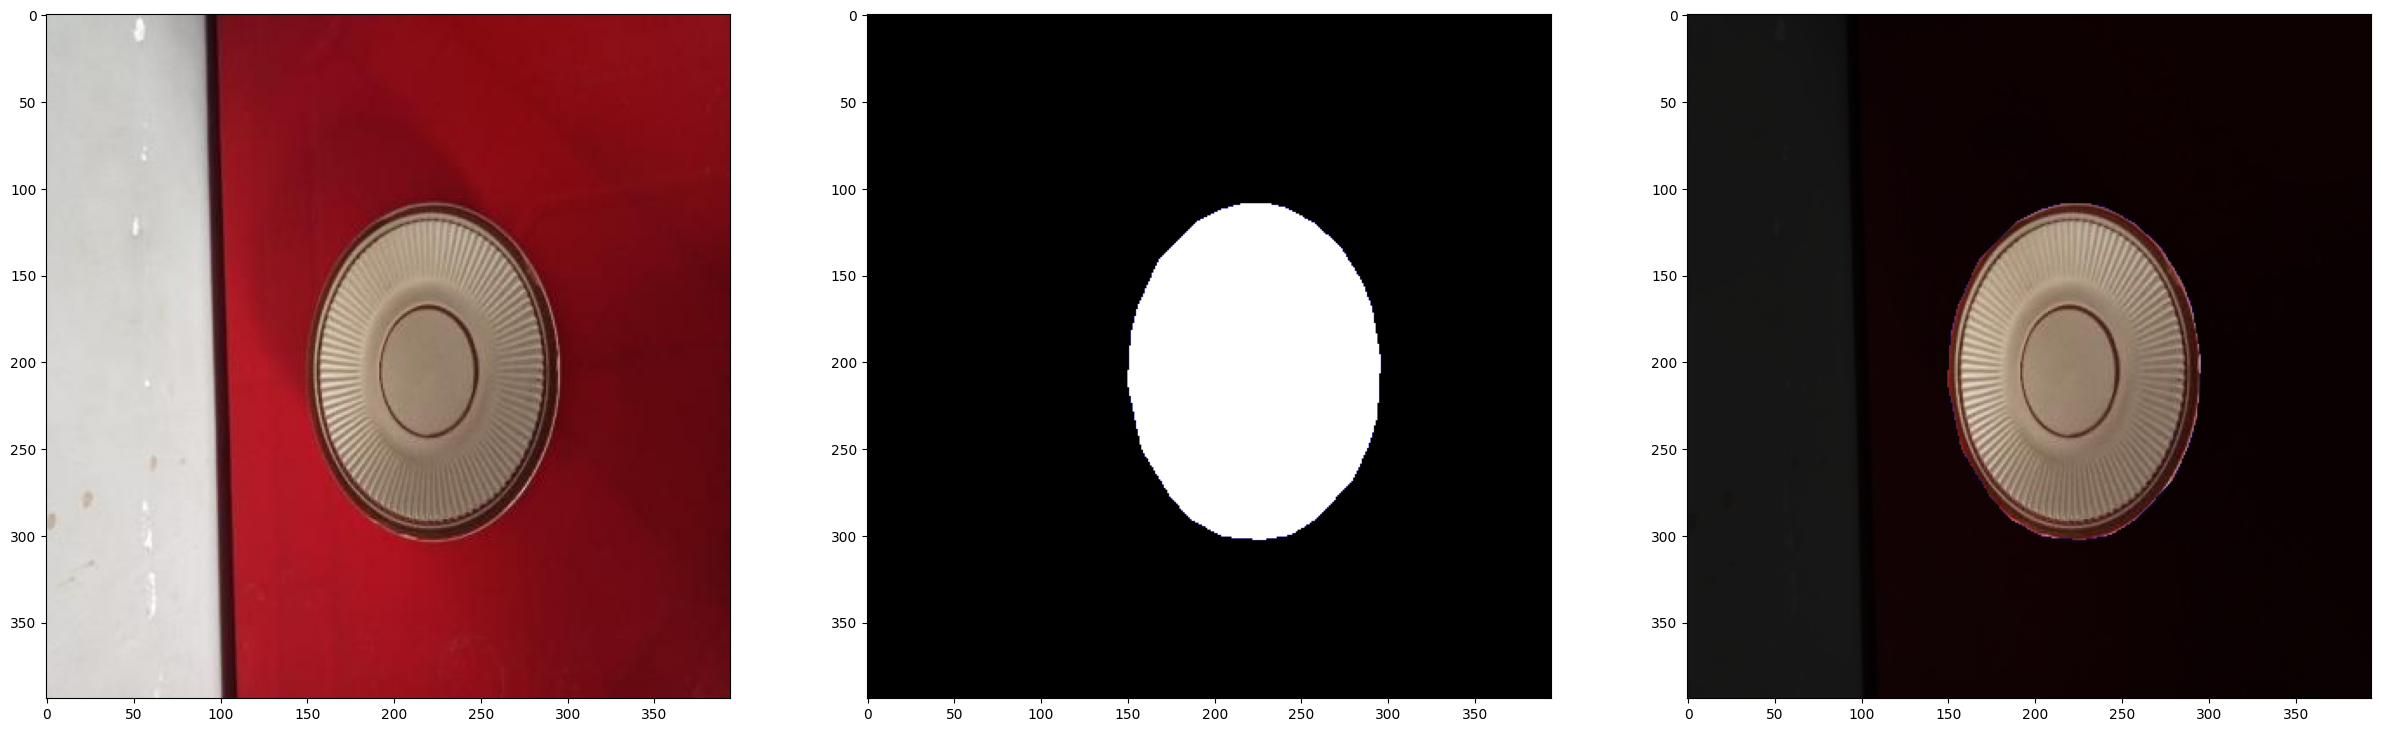

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = imgs[2]
mask = masks[2]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.9)
plt.show()

In [11]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((394, 394, 3), dtype('float64'), 1.0, 0.0)

In [12]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394, 4), dtype('float64'), 1.0, 0.0)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [13]:
import torch.nn.functional as F
import torch

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# funcion encoder
def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# clase UNet
class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        #print(x.shape, x3.shape, x2.shape, x1.shape)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

Hacemos las pruebas para ver que todo está bien.

In [14]:
model = UNet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 4, 512, 512])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [16]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 394, 394]), torch.Size([1, 4, 394, 394]))

In [19]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=40)

Epoch 1/40 loss 0.45983
Epoch 2/40 loss 0.45573
Epoch 3/40 loss 0.44421
Epoch 4/40 loss 0.43763
Epoch 5/40 loss 0.43025
Epoch 6/40 loss 0.42271
Epoch 7/40 loss 0.41580
Epoch 8/40 loss 0.40918
Epoch 9/40 loss 0.40276
Epoch 10/40 loss 0.39628
Epoch 11/40 loss 0.38981
Epoch 12/40 loss 0.38370
Epoch 13/40 loss 0.37764
Epoch 14/40 loss 0.37160
Epoch 15/40 loss 0.36570
Epoch 16/40 loss 0.35990
Epoch 17/40 loss 0.35421
Epoch 18/40 loss 0.34864
Epoch 19/40 loss 0.34318
Epoch 20/40 loss 0.33785
Epoch 21/40 loss 0.33261
Epoch 22/40 loss 0.32746
Epoch 23/40 loss 0.32238
Epoch 24/40 loss 0.31737
Epoch 25/40 loss 0.31243
Epoch 26/40 loss 0.30754
Epoch 27/40 loss 0.30269
Epoch 28/40 loss 0.29788
Epoch 29/40 loss 0.29311
Epoch 30/40 loss 0.28837
Epoch 31/40 loss 0.28367
Epoch 32/40 loss 0.27905
Epoch 33/40 loss 0.27450
Epoch 34/40 loss 0.27002
Epoch 35/40 loss 0.26561
Epoch 36/40 loss 0.26126
Epoch 37/40 loss 0.25700
Epoch 38/40 loss 0.25280
Epoch 39/40 loss 0.24868
Epoch 40/40 loss 0.24462


Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

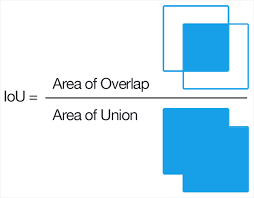

In [20]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [21]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.24064 iou 0.99583
Epoch 2/100 loss 0.26922 iou 0.91668
Epoch 3/100 loss 0.21941 iou 0.99326
Epoch 4/100 loss 0.21036 iou 0.98072
Epoch 5/100 loss 0.19492 iou 0.99491
Epoch 6/100 loss 0.18249 iou 0.99034
Epoch 7/100 loss 0.17154 iou 0.98744
Epoch 8/100 loss 0.16105 iou 0.98839
Epoch 9/100 loss 0.15120 iou 0.99108
Epoch 10/100 loss 0.14165 iou 0.99378
Epoch 11/100 loss 0.13283 iou 0.99525
Epoch 12/100 loss 0.12445 iou 0.99588
Epoch 13/100 loss 0.11661 iou 0.99565
Epoch 14/100 loss 0.10955 iou 0.99509
Epoch 15/100 loss 0.10305 iou 0.99514
Epoch 16/100 loss 0.09687 iou 0.99594
Epoch 17/100 loss 0.09116 iou 0.99653
Epoch 18/100 loss 0.08590 iou 0.99674
Epoch 19/100 loss 0.08112 iou 0.99680
Epoch 20/100 loss 0.07665 iou 0.99708
Epoch 21/100 loss 0.07241 iou 0.99712
Epoch 22/100 loss 0.06843 iou 0.99712
Epoch 23/100 loss 0.06473 iou 0.99718
Epoch 24/100 loss 0.06135 iou 0.99732
Epoch 25/100 loss 0.05821 iou 0.99747
Epoch 26/100 loss 0.05528 iou 0.99756
Epoch 27/100 loss 0.0

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

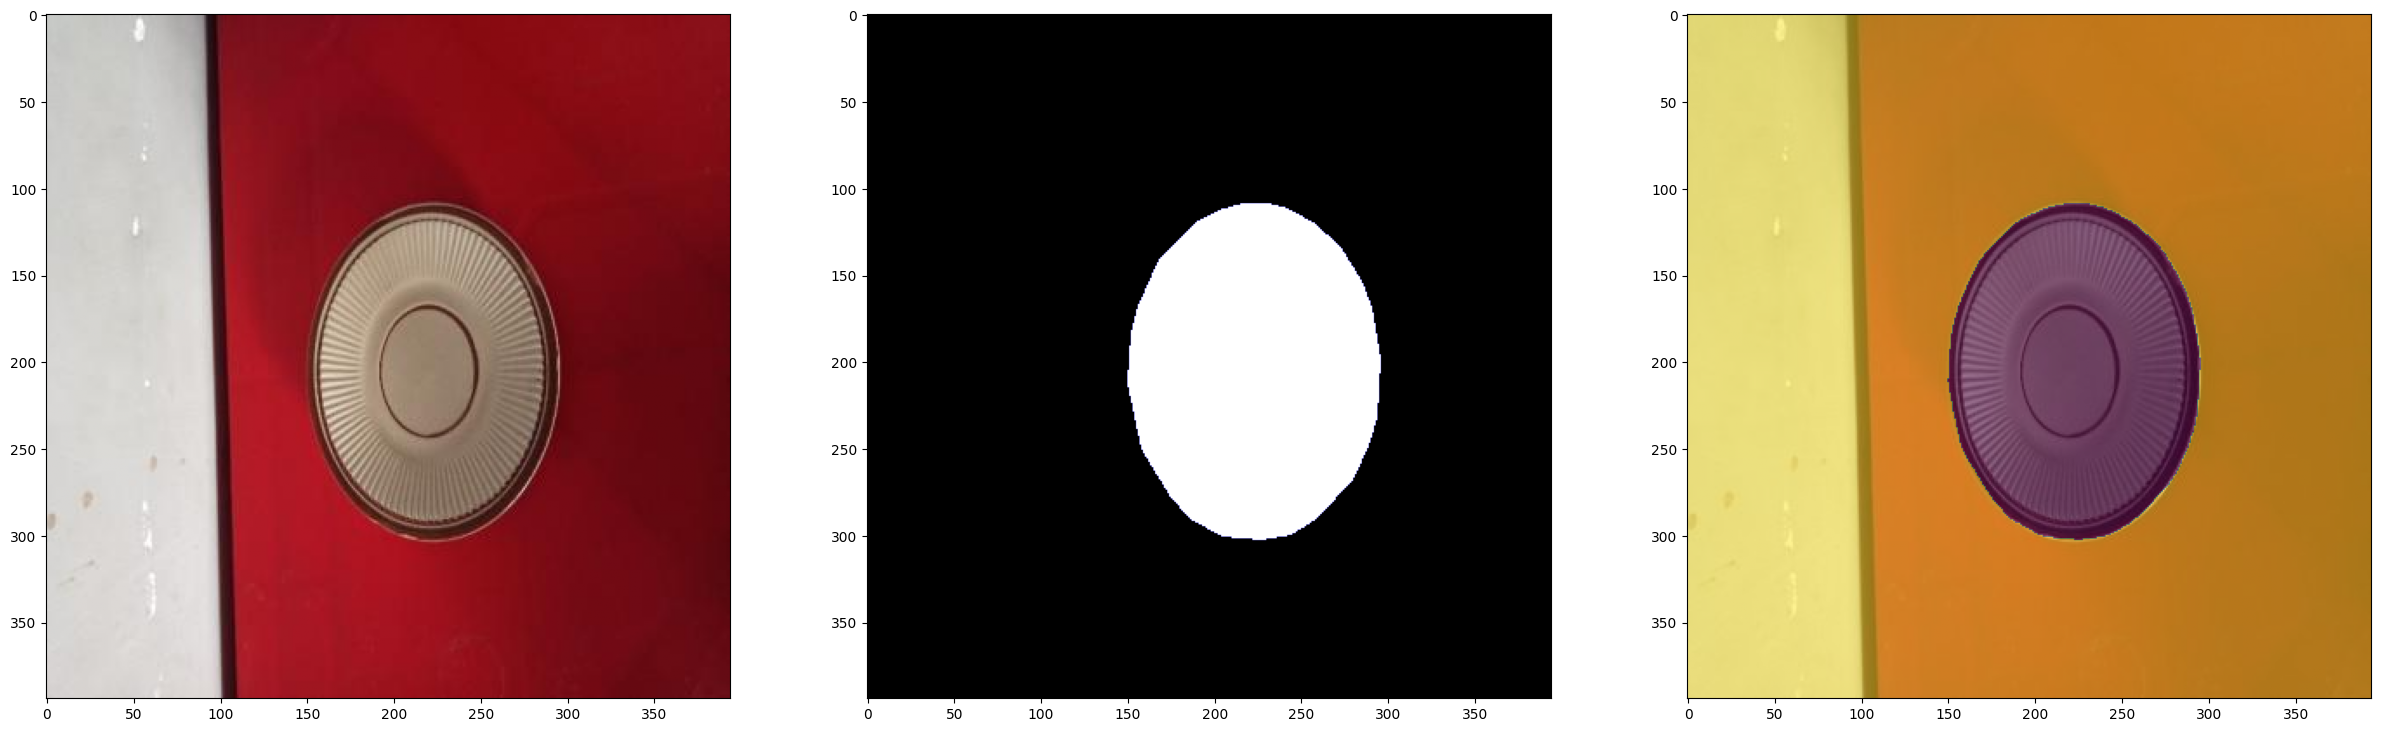

In [22]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.5)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [23]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [25]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(975, 61)

In [26]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 394, 394]), torch.Size([4, 394, 394]))

In [27]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 4, 394, 394]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [30]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()

        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"/content/drive/MyDrive/2parcial/Checkpoint/UNetResNet_model_seg_{epoch}.pt")

    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente.

In [31]:
model = UNet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.37566 test_iou 0.40572: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]



Epoch 1/10 loss 0.47110 iou 0.13684 test_loss 0.37566 test_iou 0.40572


test_loss 0.28719 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]



Epoch 2/10 loss 0.32391 iou 0.56968 test_loss 0.28719 test_iou 0.66667


test_loss 0.27810 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



Epoch 3/10 loss 0.28698 iou 0.66667 test_loss 0.27810 test_iou 0.66667


test_loss 0.25977 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]



Epoch 4/10 loss 0.26910 iou 0.66667 test_loss 0.25977 test_iou 0.66667


test_loss 0.24906 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]



Epoch 5/10 loss 0.25963 iou 0.66667 test_loss 0.24906 test_iou 0.66667


test_loss 0.24880 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]



Epoch 6/10 loss 0.25035 iou 0.66667 test_loss 0.24880 test_iou 0.66667


test_loss 0.24137 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]



Epoch 7/10 loss 0.23934 iou 0.66667 test_loss 0.24137 test_iou 0.66667


test_loss 0.23587 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]



Epoch 8/10 loss 0.23239 iou 0.66667 test_loss 0.23587 test_iou 0.66667


test_loss 0.23207 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]



Epoch 9/10 loss 0.22829 iou 0.66667 test_loss 0.23207 test_iou 0.66667


test_loss 0.25282 test_iou 0.66667: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch 10/10 loss 0.22338 iou 0.66667 test_loss 0.25282 test_iou 0.66667


Vemos que la precisión de nuestro modelo es bastante bajo lo cual nos indica que el modelo carece de datos o que necesita más tiempo de entrenamiento.

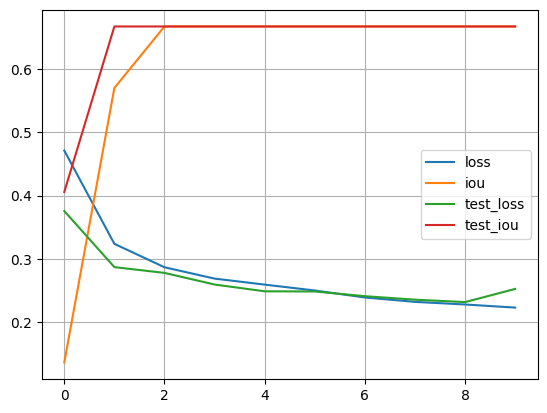

In [32]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [78]:
classes = ['platosopero', 'platosegundo', 'platillo', 'background']
colors = ['#1f77b4', '#008000', '#ff0000', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

8


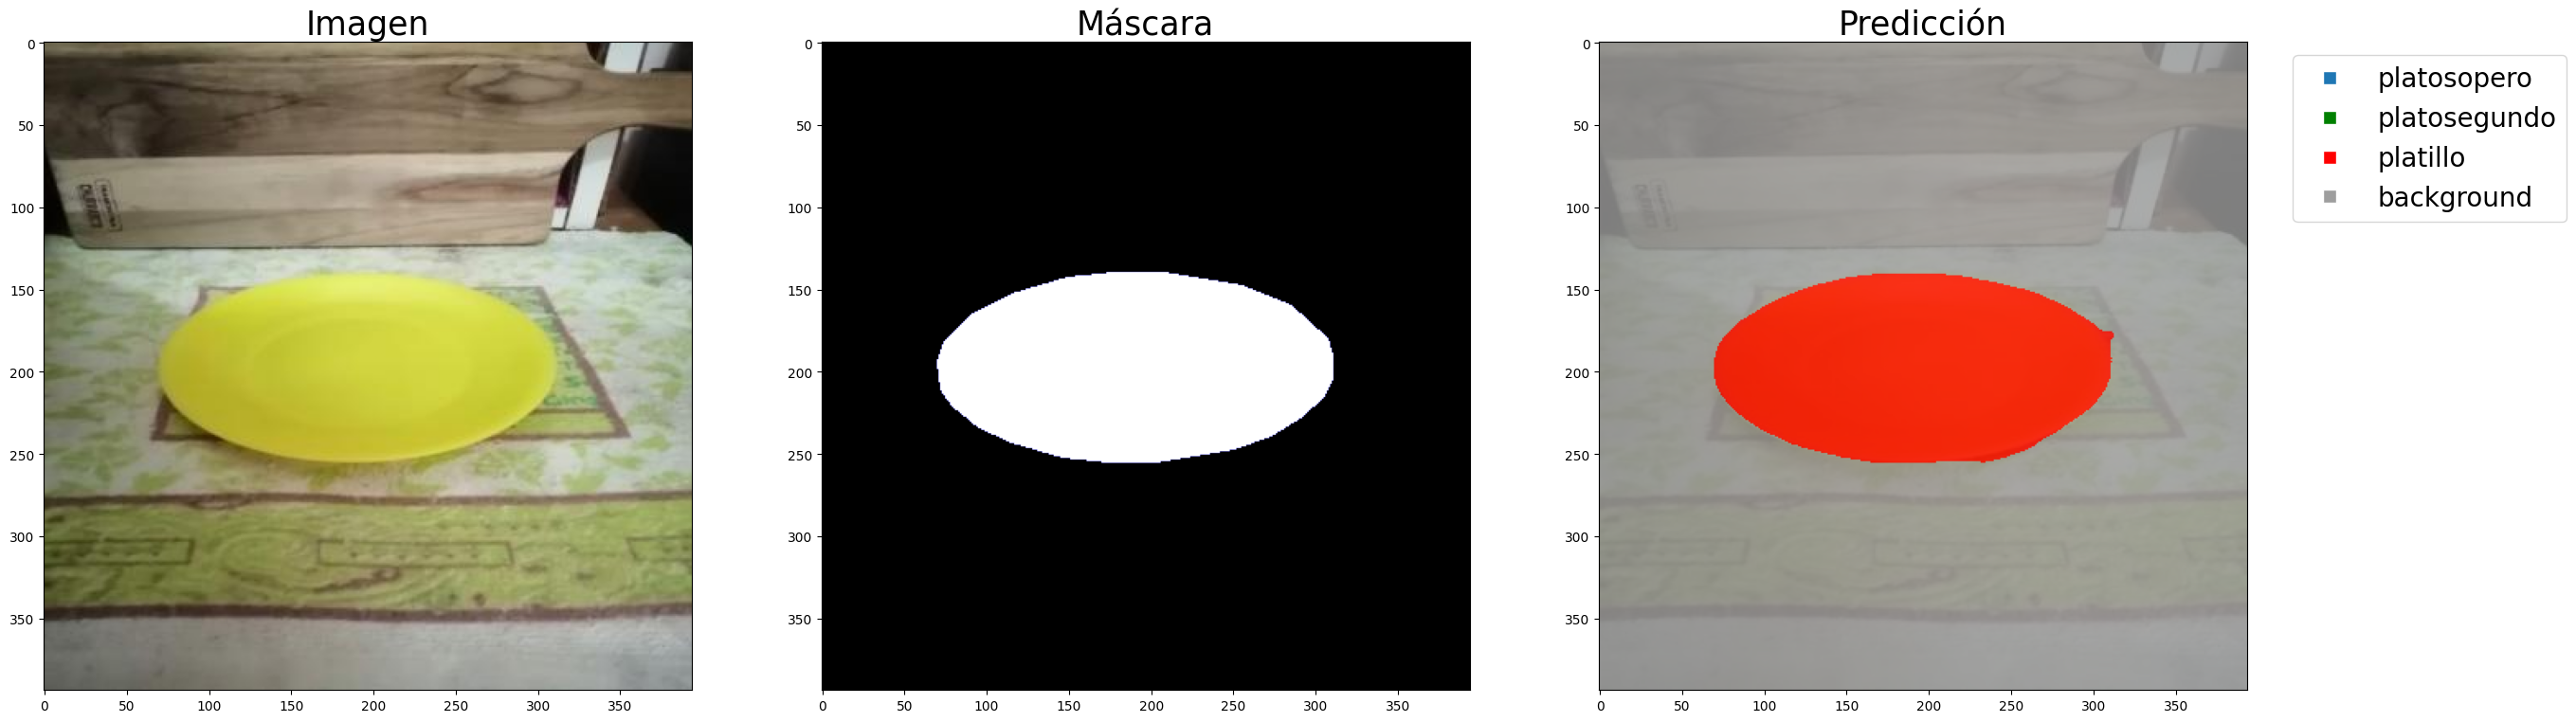

In [82]:
import random
import matplotlib.colors as mcolors
ix = random.randint(0, len(dataset['test']) - 1)
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [40]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Probamos para ver que todo este correctamente.

In [41]:
model = UNetResnet()
output = model(torch.randn((1,3,512,512)))
output.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.2MB/s]


torch.Size([1, 4, 512, 512])

#### Entrenamos el modelo

Procedemos a entrenar el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente.

In [42]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=15)

test_loss 0.44813 test_iou 0.24720: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]



Epoch 1/15 loss 0.55349 iou 0.15988 test_loss 0.44813 test_iou 0.24720


test_loss 0.36225 test_iou 0.36571: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]



Epoch 2/15 loss 0.40072 iou 0.26957 test_loss 0.36225 test_iou 0.36571


test_loss 0.29080 test_iou 0.46180: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]



Epoch 3/15 loss 0.30738 iou 0.42577 test_loss 0.29080 test_iou 0.46180


test_loss 0.22607 test_iou 0.46194: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]



Epoch 4/15 loss 0.23816 iou 0.52216 test_loss 0.22607 test_iou 0.46194


test_loss 0.22766 test_iou 0.42324: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]



Epoch 5/15 loss 0.18919 iou 0.56461 test_loss 0.22766 test_iou 0.42324


test_loss 0.15485 test_iou 0.55508: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 6/15 loss 0.15376 iou 0.60822 test_loss 0.15485 test_iou 0.55508


test_loss 0.13426 test_iou 0.53270: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]



Epoch 7/15 loss 0.11913 iou 0.67254 test_loss 0.13426 test_iou 0.53270


test_loss 0.12012 test_iou 0.56015: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]



Epoch 8/15 loss 0.09624 iou 0.69586 test_loss 0.12012 test_iou 0.56015


test_loss 0.14268 test_iou 0.52256: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]



Epoch 9/15 loss 0.08190 iou 0.73470 test_loss 0.14268 test_iou 0.52256


test_loss 0.10586 test_iou 0.60176: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]



Epoch 10/15 loss 0.06572 iou 0.77575 test_loss 0.10586 test_iou 0.60176


test_loss 0.12071 test_iou 0.54650: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]



Epoch 11/15 loss 0.06153 iou 0.78755 test_loss 0.12071 test_iou 0.54650


test_loss 0.11409 test_iou 0.58613: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]



Epoch 12/15 loss 0.04781 iou 0.82918 test_loss 0.11409 test_iou 0.58613


test_loss 0.10640 test_iou 0.55170: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]



Epoch 13/15 loss 0.04318 iou 0.82485 test_loss 0.10640 test_iou 0.55170


test_loss 0.11643 test_iou 0.58677: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]



Epoch 14/15 loss 0.05167 iou 0.78355 test_loss 0.11643 test_iou 0.58677


test_loss 0.09688 test_iou 0.65546: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Epoch 15/15 loss 0.03847 iou 0.83531 test_loss 0.09688 test_iou 0.65546


Vemos que la precisióon de nuestro modelo mejoró bastante a comparación del modelo anterior llegando a una precisión de `81.90%`.

In [43]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet_Tranfer.pth')

In [44]:
# Crear una instancia del modelo
modelo_cargado =UNetResnet()
# Cargar los parámetros del modelo guardado en la instancia
modelo_cargado.load_state_dict(torch.load('/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet_Tranfer.pth'))

<All keys matched successfully>

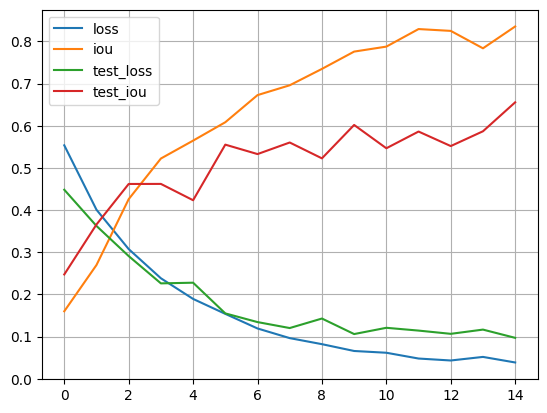

In [45]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

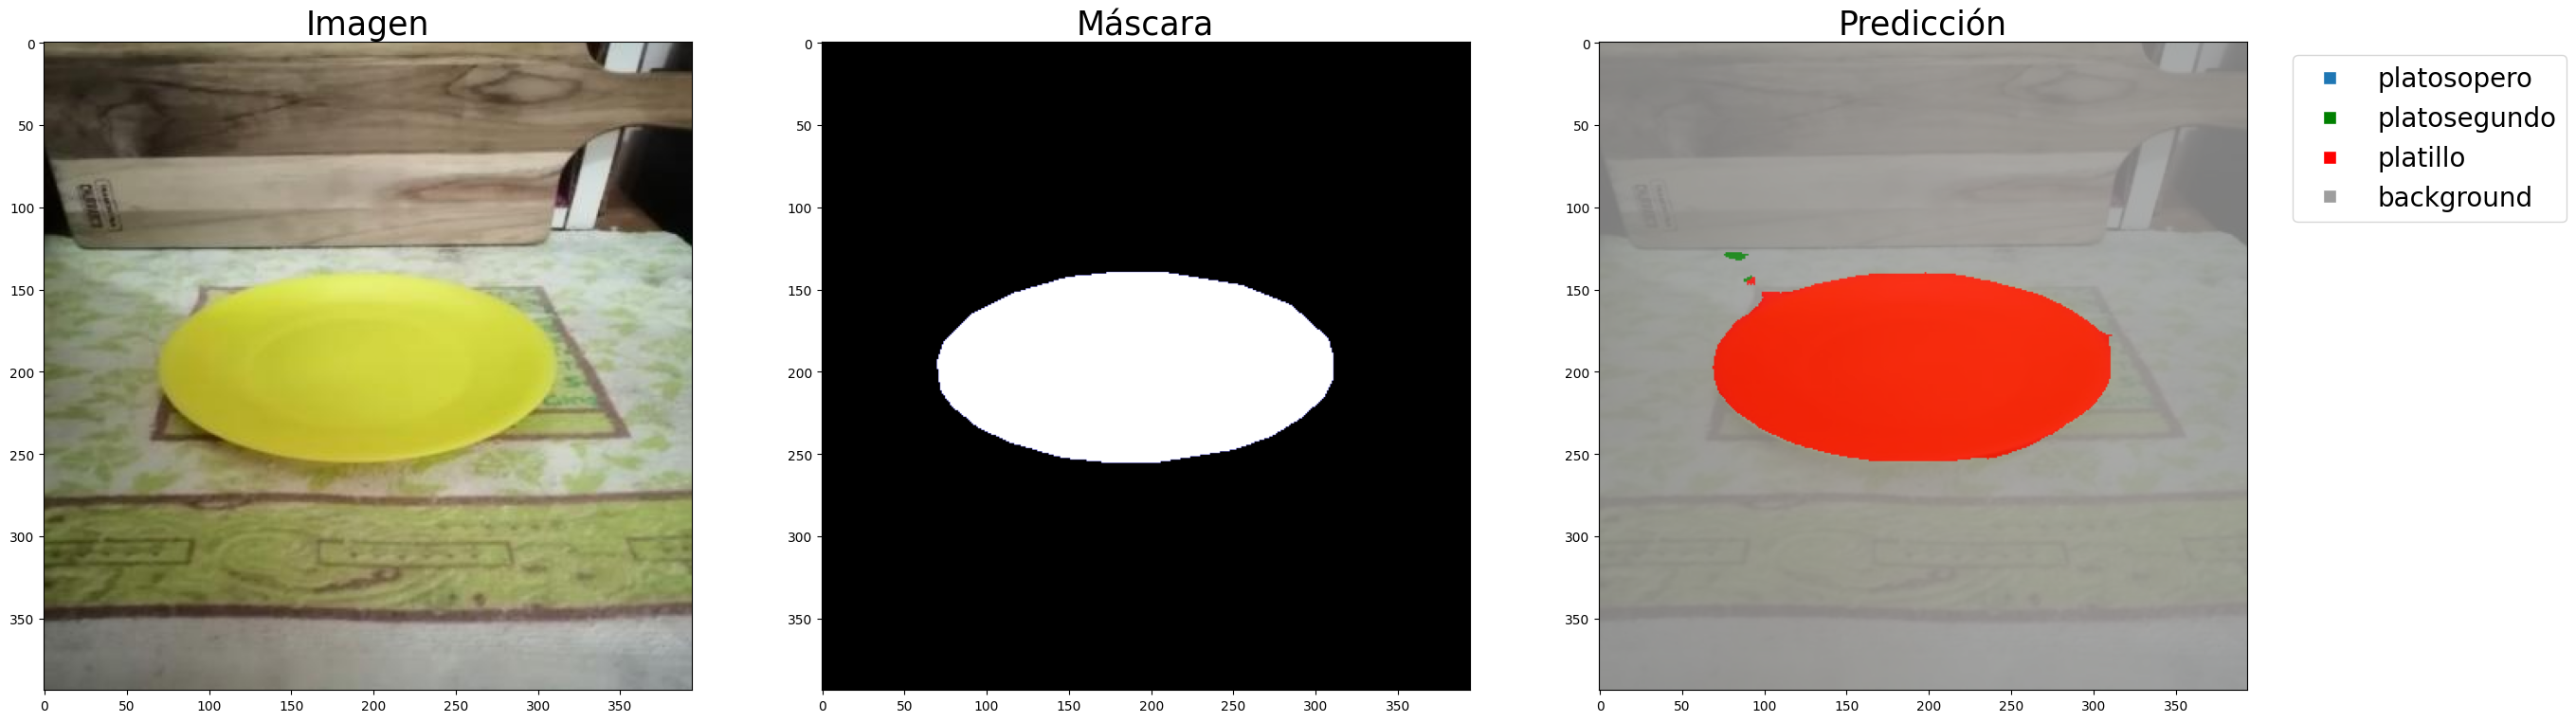

In [63]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

#### Reentrenameinto

Ahora haremos un reentrenamiento del modelo para ver si mejora la precisión del modelo con un `learning rate` más pequeño. Para eso cargaremos el modelo anterior que lo guardamos y procedemos a reentrenarlo. Para ver si se logra algunas mejoras.

In [64]:
# cargar modelo
model = UNetResnet()
model.load_state_dict(torch.load('/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet_Tranfer.pth'))

<All keys matched successfully>

In [65]:
hist = fit(model, dataloader, epochs=5, lr=3e-5)

test_loss 0.09637 test_iou 0.66682: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]



Epoch 1/5 loss 0.02841 iou 0.90428 test_loss 0.09637 test_iou 0.66682


test_loss 0.08962 test_iou 0.69749: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]



Epoch 2/5 loss 0.02308 iou 0.95770 test_loss 0.08962 test_iou 0.69749


test_loss 0.09796 test_iou 0.69214: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]



Epoch 3/5 loss 0.02230 iou 0.94957 test_loss 0.09796 test_iou 0.69214


test_loss 0.08633 test_iou 0.70784: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]



Epoch 4/5 loss 0.02045 iou 0.96683 test_loss 0.08633 test_iou 0.70784


test_loss 0.08786 test_iou 0.70211: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Epoch 5/5 loss 0.01916 iou 0.96934 test_loss 0.08786 test_iou 0.70211


In [70]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet_Fine.pth')

Efectivamente, el modelo mejora su precisión a `87.80%` después de reentrarlo con un `learning rate` más pequeño.

In [71]:
# cargar modelo
model = UNetResnet()
model.load_state_dict(torch.load('/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet_Fine.pth'))

<All keys matched successfully>

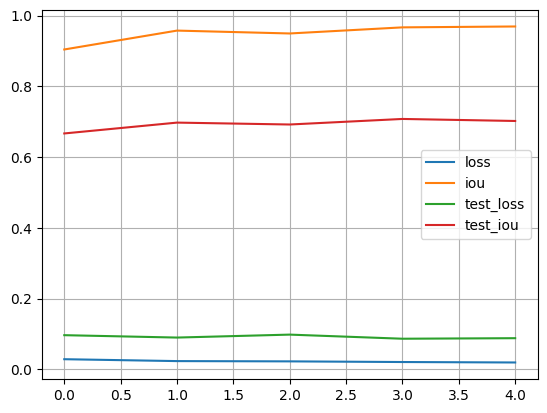

In [66]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

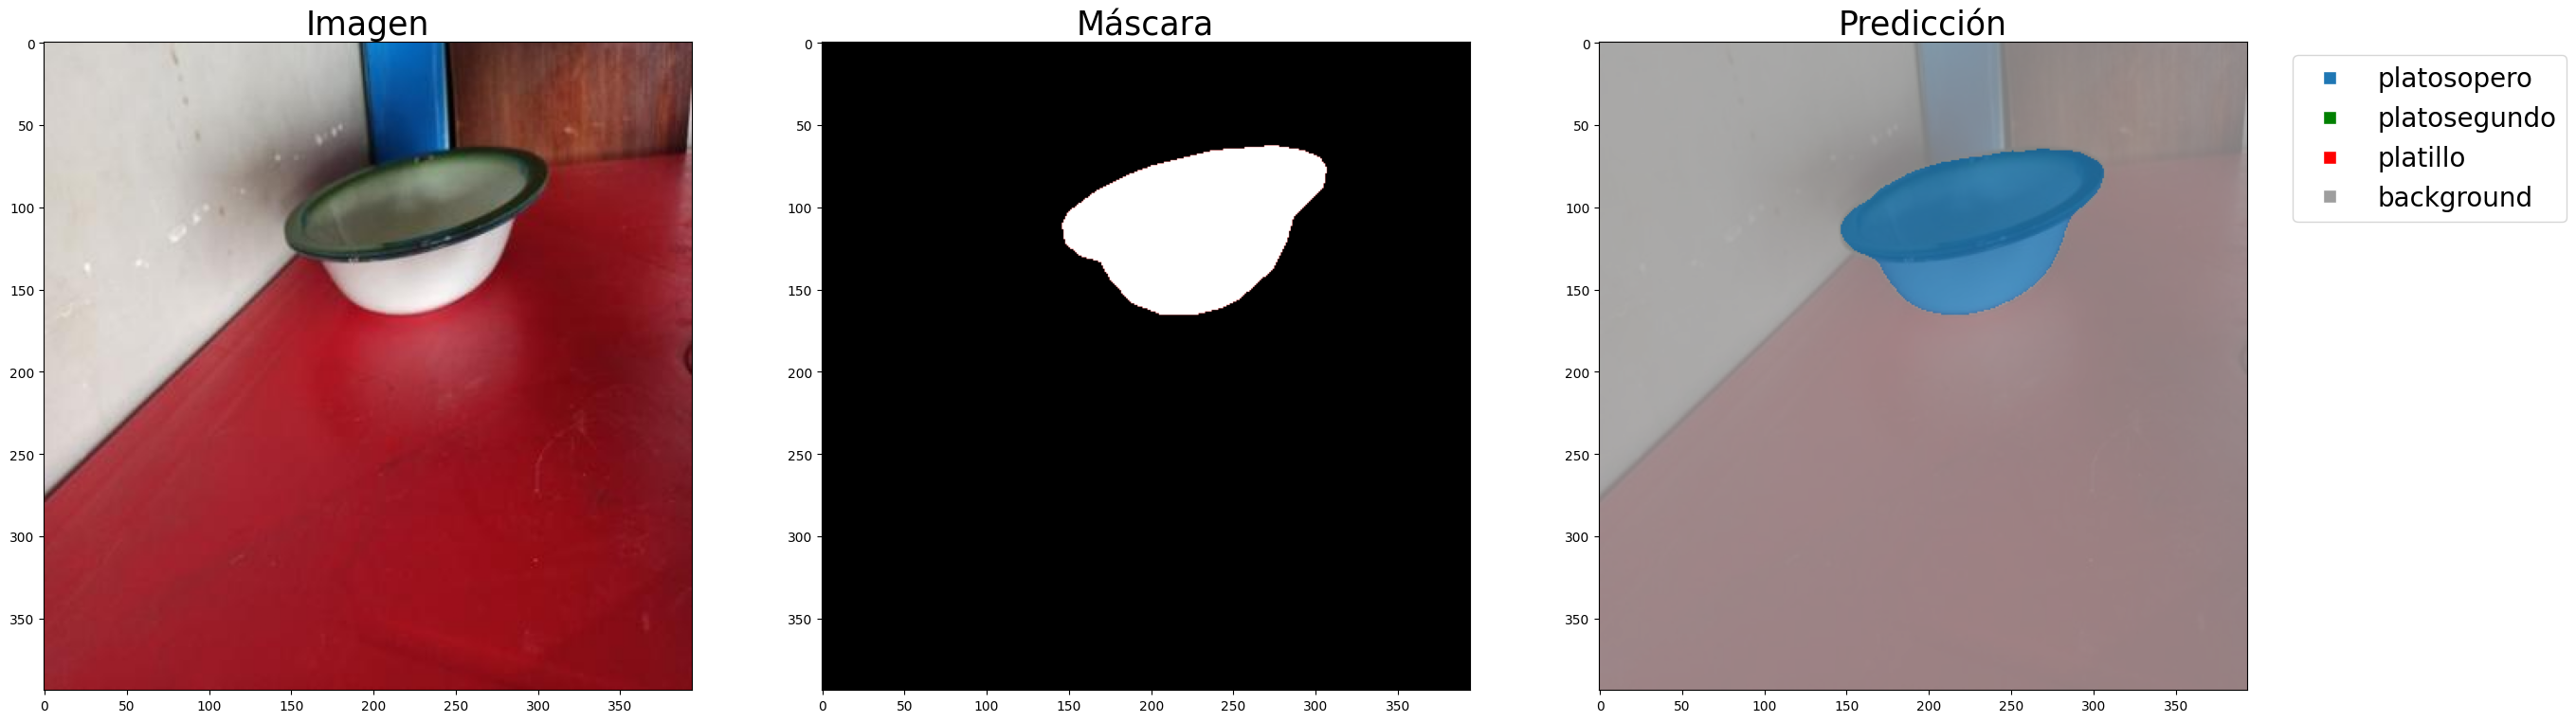

In [69]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)